## Analysis of factors affecting the incidence of Covid-19 in China
#### The primary goals of this project are 
1. to explore incidence of covid-19 in different areas in China and its relationship with several factors. 
2. to predict futurn incidence and compare.


#### Factors: 
1. per capita disposable income 
2. male to female ratio 
3. population flow rate 
4. urbanization level  
5. per capita medical resource occupancy 


#### Work process:
1. web scraping
2. data cleaning
3. data parsing and visualization
4. machine learning
5. report writing

## 1. Web scraping
### Data recourses:
DXY.cn (Chinese: 丁香园; pinyin: Dīngxiāng Yuán) 
It is an online community for physicians, health care professionals, pharmacies and facilities in China, also for foreigners, established on July 23, 2000 by Tiantian Li.

We use the page with title: "COVID-19 Global Pandemic Real-time Report"
Here is the link below:
https://ncov.dxy.cn/ncovh5/view/pneumonia


In [4]:
import requests
import re
import json
from bs4 import BeautifulSoup
from tqdm import tqdm


response = requests.get('https://ncov.dxy.cn/ncovh5/view/pneumonia')
home_page = response.content.decode()

soup = BeautifulSoup(home_page,'lxml')
script = soup.find(id = 'getListByCountryTypeService2true')
text = script.text

json_str = re.findall(r'\[.*\]',text) #类型是list
json_str_1 = ",".join(json_str) #类型是string

url= 'https://ncov.dxy.cn/ncovh5/view/pneumonia'
response = requests.get('https://ncov.dxy.cn/ncovh5/view/pneumonia')
home_page = response.content.decode()

last_day_corona_virus =json.loads(json_str_1)

with open('last_day_corona_virus','w') as fp:
    json.dump(last_day_corona_virus,fp) 

class CoronaVirusSpider(object):
    def __init__(self):
        self.home_url = 'https://ncov.dxy.cn/ncovh5/view/pneumonia'

    def get_content_from_url(self, url):
        response = requests.get(url)
        return response.content.decode()

    # translate the data in front page and return Python data
    def parse_home_page(self, home_page):
        soup = BeautifulSoup(home_page, 'lxml')
        script = soup.find(id='getListByCountryTypeService2true')
        text = script.text
        json_str = re.findall(r'\[.+\]', text)[0]
        # print(json_str)
        last_day_corona_virus = json.loads(json_str)
        # print(last_day_corona_virus)
        data = json.loads(json_str)
        return data

    def save(self, data, path):
        with open(path, 'w')as fp:
            json.dump(data, fp)

    def crawl_last_day_corona_virus(self):
        home_page = self.get_content_from_url(self.home_url)
        last_day_corona_virus = self.parse_home_page(home_page)
        self.save(last_day_corona_virus, 'data/last_day_corona_virus.json')

    def run(self):
        self.crawl_last_day_corona_virus()

    def crawl_corona_virus(self, statistic_data_url=None):
        with open('data/last_day_corona_virus.json') as  fp:
            last_day_corona_virus = json.load(fp)
        # print (last_day_corona_virus)
        corona_virus = []
        for country in tqdm(last_day_corona_virus, 'collect the Covid-19 Data in all of the world from 23/Jan'):
            statistics_data_url = country['statisticsData']
            statistics_data_json_str = self.get_content_from_url(statistics_data_url)
            # print(statistics_data_json_str)
            
            statistics_data = json.loads(statistics_data_json_str)['data']
            #print(statistics_data)
            for one_day in statistics_data:
                one_day['provinceName'] = country['provinceName']
                one_day['countryShortCode'] = country['countryShortCode']
            # print(statistics_data)
            corona_virus.extend(statistics_data)
        self.save(corona_virus, 'data/corona_virus.json')
    
    def crawl_last_day_corona_virus_of_china(self):
        home_page = self.get_content_from_url(self.home_url)
        soup = BeautifulSoup(home_page,'lxml')
        script = soup.find(id = 'getAreaStat')
        text = script.text
        json_str = re.findall(r'\[.*\]',text)
        json_str_2 = ",".join(json_str)
        data = json.loads(json_str_2)
        
        self.save(data,'data/last_day_corona_virus_of_china.json')
    
    def crawl_corona_virus_of_china(self):
        with open('data/last_day_corona_virus_of_china.json') as fp:
            last_day_corona_virus_of_china = json.load(fp)
            
        corona_virus = []
        
        for country in tqdm(last_day_corona_virus_of_china, 'collect the Covid-19 Data in all provinces of china from 22/Jan'):
            statistics_data_url = country['statisticsData']
            statistics_data_json_str = self.get_content_from_url(statistics_data_url)
            # print(statistics_data_json_str)
            
            statistics_data = json.loads(statistics_data_json_str)['data']
            #print(statistics_data)
            for one_day in statistics_data:
                one_day['provinceName'] = country['provinceName']
            corona_virus.extend(statistics_data)
            #print(corona_virus)
            
        self.save(corona_virus,'data/corona_virus_of_china.json')
    
    def run(self):
        self.crawl_last_day_corona_virus()
        self.crawl_corona_virus()
        self.crawl_last_day_corona_virus_of_china()
        self.crawl_corona_virus_of_china()
        
if __name__ == '__main__':
    spider = CoronaVirusSpider()
    spider.run()

collect the Covid-19 Data in all of the world from 23/Jan: 100%|██████████| 215/215 [00:42<00:00,  5.18it/s]
collect the Covid-19 Data in all provinces of china from 22/Jan: 100%|██████████| 34/34 [00:06<00:00,  5.25it/s]


## 2. Visualization

### (1) Overview map

## china corona map

In [16]:
iimport matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.figure
from matplotlib.patches import Polygon
from mpl_toolkits.basemap import Basemap

#准备行政区域确证分布数据
last_day_corona_virus_of_china = pd.read.json(data/last_day_corona_virus_of_china.json)
current_confirmed_count = last_day_corona_virus_of_china.pivot_table(value="currentConfirmedCount",index='provinceName')
data = current_confirmed_count.to_dict()["currentConfirmedCount"]

#绘制行政区确证分布图
lat_min = 0
lat_max = 60
lon_min = 70
lon_max = 140

handles = [
    matplotlib.patches.Patch(color='#ffaa85',alpha = 1, linewidth=0),
    matplotlib.patches.Patch(color='#ff7b69',alpha = 1, linewidth=0),
    matplotlib.patches.Patch(color='#bf2121',alpha = 1, linewidth=0),
    matplotlib.patches.Patch(color='#7f1818',alpha = 1, linewidth=0),
]
labels = ['1-9 persons','10-99 persons','100-999 persons','>1000 persons']

fig = plt.figure(figsize=(8,10))

axes = fig.add_axes((0.1,0.12,0.8,0.8))  #rect=1,b,w,h
m = Basemap(llcrnrlon=lon_min,urcrnrlon=lon_max,llcrnrlat=lat_min,urcrnrlat=lat_max,resolution='l',ax=axes)
m.readshapefile('china-shapefiles-master/china','province',drawbounds=True)
m.readshapefile('china-shapefiles-master/china nine dotted line','p',drawbounds=True)
m.drawcoastlines(color='black')
m.drawcountries(color='black')
m.drawparallels(np.arange(lat_min,lat_max,10),labels=[1,0,0,0])
m.drawmeridians(np.arange(lon_min,lon_max,10), labels=[0,0,0,1]) #画纬度线

for info, shape in zip(m.province_info, m.province):
    pname = info['OWNER'].strip('\x00')
    fcname = info['FCNAME'].strip('\x00')
    if pname != fcname: # 不绘制海岛
        continue
                
    for key in data.keys():
        if key in pname:
            if data[key] == 0:
                color = '#f0f0f0'
            elif data[key] < 10:
                color = '#ffaa85'
            elif data[key] <100:
                color = '#ff7b69'
            elif data[key] <1000:
                color = 'bf2121'
            else:
                color = '#7f1818'
            break
                
    poly = Polygon(shape, facecolor=color, edgecolor=color)
    axes.add_patch(poly)
                
axes.legend(handles, labels, bbox_to_anchor=(0.5,-0.11),loc='lower center',ncol=4)
axes.set_title('china corona virus map')
fig.savefig('china corona virus map.png')
plt.show

ModuleNotFoundError: No module named 'cartopy'

## 3. Mechine learning

### (1) Collect Revelent Factors

In [11]:
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import seaborn as sns 
%matplotlib inline 

In [12]:
Factors=pd.read_csv('Sum of Seven Factors.csv')
Factors.head()

provinceName  Province  AvgSalary  AvgDisposableIncome  AvgSalaryofMedical  \
0          北京市   BeiJing     145766             62361.22             84725.0   
1          天津市  TianJing     100731             39506.15             52472.0   
2          河北省     HeBei      68717             23445.65             41185.0   
3          山西省    ShanXi      65917             21990.14             36832.0   
4       内蒙古自治区   NeiMeng      73835             28375.65             43148.0   

   AvgMedicalPerPerson  Unemployment  PopullationGrowth  \
0                  119          7.91               8.24   
1                   67         25.81               6.67   
2                   61         38.04              11.26   
3                   66         24.56               9.63   
4                   74         27.04               8.35   

   FolatingPopulationProportion  
0                         11.68  
1                          4.96  
2                          4.33  
3                          6.28  
4                         10.87

In [13]:
print('Number of rows:',len(Factors),'\n')
print(Factors.head(7))

Number of rows: 31 

  provinceName  Province  AvgSalary  AvgDisposableIncome  AvgSalaryofMedical  \
0          北京市   BeiJing     145766             62361.22             84725.0   
1          天津市  TianJing     100731             39506.15             52472.0   
2          河北省     HeBei      68717             23445.65             41185.0   
3          山西省    ShanXi      65917             21990.14             36832.0   
4       内蒙古自治区   NeiMeng      73835             28375.65             43148.0   
5          辽宁省  LiaoNing      67324             29701.45             44868.0   
6          吉林省     JiLin      68533             22798.37             41840.0   

   AvgMedicalPerPerson  Unemployment  PopullationGrowth  \
0                  119          7.91               8.24   
1                   67         25.81               6.67   
2                   61         38.04              11.26   
3                   66         24.56               9.63   
4                   74         27.04       

### （2）Visualization of Different Factors

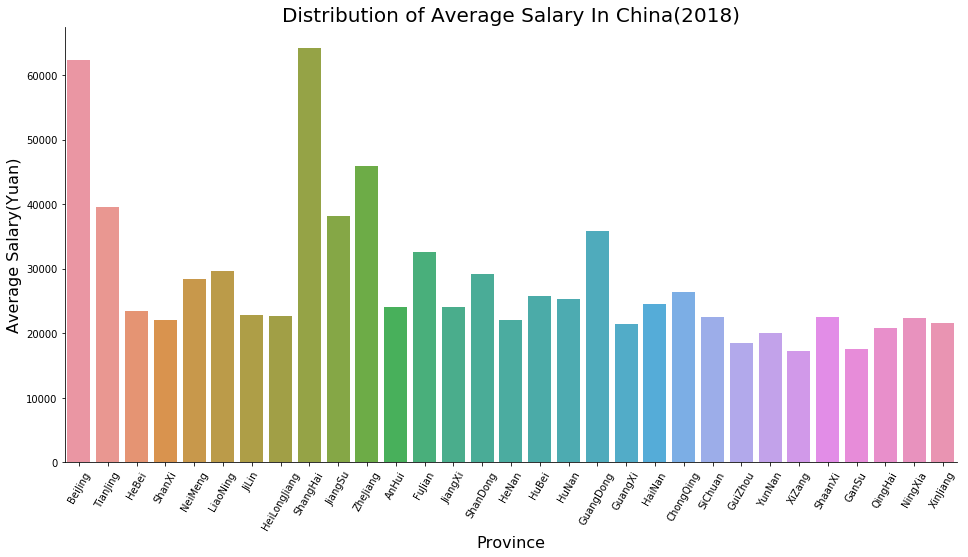

In [14]:
fig,ax=plt.subplots(figsize=(16,8))
sns.barplot(x="Province",y="AvgDisposableIncome",data=Factors)

for tick in ax.get_xticklabels():
    tick.set_rotation(60)
ax.set_title('Distribution of Average Salary In China(2018)')
ax.set_ylabel('Average Salary(Yuan)')
ax.title.set_fontsize(20)
ax.xaxis.label.set_fontsize(16)
ax.yaxis.label.set_fontsize(16)
sns.despine()
plt.savefig('Distribution of Average Salary In China(2018).jpg')

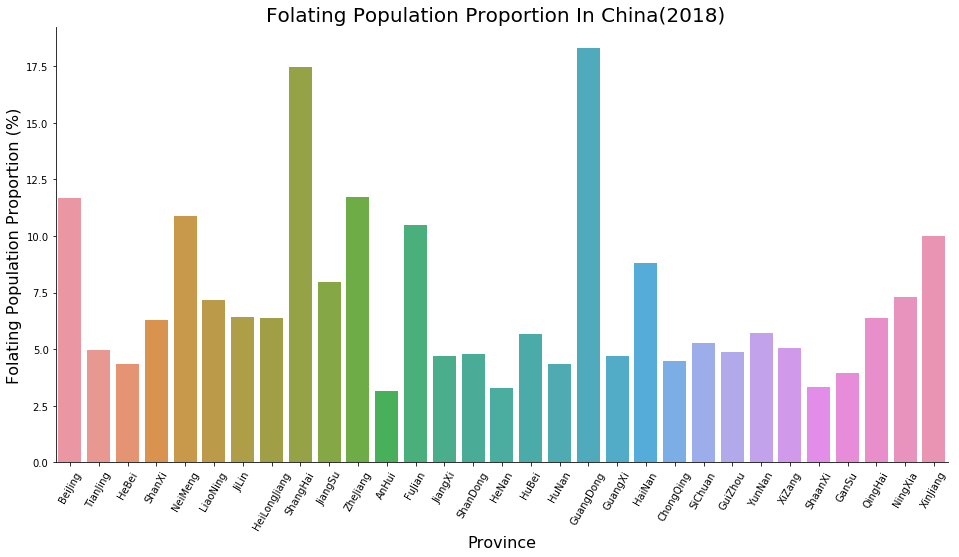

In [15]:
fig,ax=plt.subplots(figsize=(16,8))
sns.barplot(x="Province",y="FolatingPopulationProportion",data=Factors)
for tick in ax.get_xticklabels():
    tick.set_rotation(60)
ax.set_title('Folating Population Proportion In China(2018)  ')
ax.set_ylabel('Folating Population Proportion (%)')
ax.title.set_fontsize(20)
ax.xaxis.label.set_fontsize(16)
ax.yaxis.label.set_fontsize(16)
sns.despine()
plt.savefig('Folating Population Proportion In China(2018).jpg')

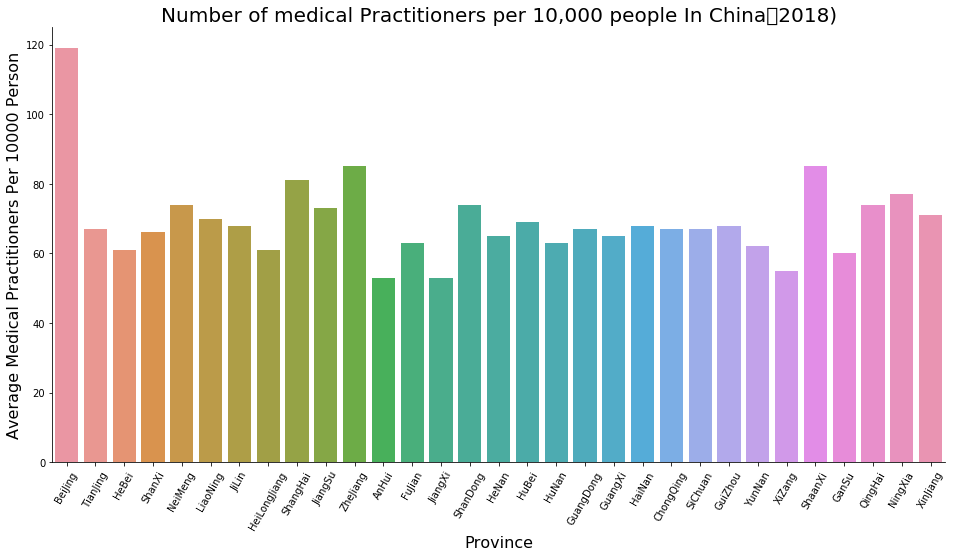

In [16]:
fig,ax=plt.subplots(figsize=(16,8))
sns.barplot(x="Province",y="AvgMedicalPerPerson",data=Factors)
for tick in ax.get_xticklabels():
    tick.set_rotation(60)
ax.set_title('Number of medical Practitioners per 10,000 people In China（2018)')
ax.set_ylabel('Average Medical Practitioners Per 10000 Person')
ax.title.set_fontsize(20)
ax.xaxis.label.set_fontsize(16)
ax.yaxis.label.set_fontsize(16)
sns.despine()
plt.savefig('Number of medical Practitioners per 10,000 people In China（2018).jpg')


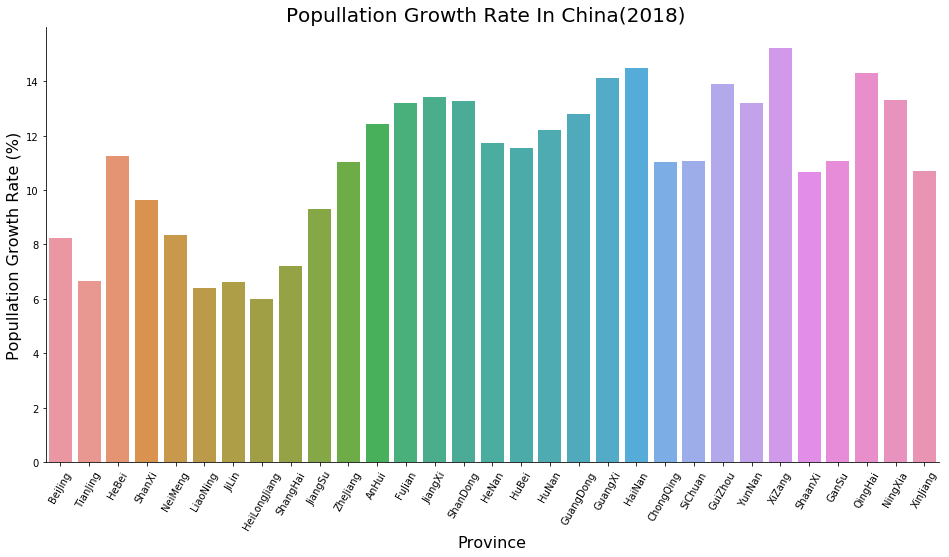

In [17]:
fig,ax=plt.subplots(figsize=(16,8))
sns.barplot(x="Province",y="PopullationGrowth",data=Factors)

for tick in ax.get_xticklabels():
    tick.set_rotation(60)
ax.set_title('Popullation Growth Rate In China(2018)  ')
ax.set_ylabel('Popullation Growth Rate (%)')
ax.title.set_fontsize(20)
ax.xaxis.label.set_fontsize(16)
ax.yaxis.label.set_fontsize(16)
sns.despine()
plt.savefig('Popullation Growth Rate In China(2018).jpg')

### (3) Merge the Json and CSV data

In [18]:
import pandas as pd
covid19=pd.read_csv('data/corona_virus_of_china.csv')
covid19.head()

provinceName    dateId  confirmedCount  confirmedIncr  curedCount  \
0     新疆维吾尔自治区  20200123               2              2           0   
1     新疆维吾尔自治区  20200124               3              1           0   
2     新疆维吾尔自治区  20200125               4              1           0   
3     新疆维吾尔自治区  20200126               5              1           0   
4     新疆维吾尔自治区  20200127              10              5           0   

   curedIncr  currentConfirmedCount  currentConfirmedIncr  deadCount  \
0          0                      2                     2          0   
1          0                      3                     1          0   
2          0                      4                     1          0   
3          0                      5                     1          0   
4          0                     10                     5          0   

   deadIncr  suspectedCount  suspectedCountIncr  
0         0               0                   0  
1         0               0                   0  
2         0               0                   0  
3         0               0                   0  
4         0               0                   0

In [19]:
covid19=covid19[ ~covid19['provinceName'].str.contains('香港')] 
covid19=covid19[ ~covid19['provinceName'].str.contains('澳门')] 
covid19=covid19[ ~covid19['provinceName'].str.contains('台湾')] 
print(covid19)
covid19.to_csv('data/corona_virus_of_china.csv',index=False)

     provinceName    dateId  confirmedCount  confirmedIncr  curedCount  \
0        新疆维吾尔自治区  20200123               2              2           0   
1        新疆维吾尔自治区  20200124               3              1           0   
2        新疆维吾尔自治区  20200125               4              1           0   
3        新疆维吾尔自治区  20200126               5              1           0   
4        新疆维吾尔自治区  20200127              10              5           0   
5        新疆维吾尔自治区  20200128              13              3           0   
6        新疆维吾尔自治区  20200129              14              1           0   
7        新疆维吾尔自治区  20200130              17              3           0   
8        新疆维吾尔自治区  20200131              18              1           0   
9        新疆维吾尔自治区  20200201              21              3           0   
10       新疆维吾尔自治区  20200202              24              3           0   
11       新疆维吾尔自治区  20200203              29              5           0   
12       新疆维吾尔自治区  20200204           

In [20]:
cols = list(covid19)
cols.insert(0, cols.pop(cols.index('provinceName')))
cols.insert(1, cols.pop(cols.index('dateId')))
covid19 = covid19.ix[:, cols]
covid19.to_csv('data/corona_virus_of_china.csv',index=False)
covid19

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


provinceName    dateId  confirmedCount  confirmedIncr  curedCount  \
0        新疆维吾尔自治区  20200123               2              2           0   
1        新疆维吾尔自治区  20200124               3              1           0   
2        新疆维吾尔自治区  20200125               4              1           0   
3        新疆维吾尔自治区  20200126               5              1           0   
4        新疆维吾尔自治区  20200127              10              5           0   
5        新疆维吾尔自治区  20200128              13              3           0   
6        新疆维吾尔自治区  20200129              14              1           0   
7        新疆维吾尔自治区  20200130              17              3           0   
8        新疆维吾尔自治区  20200131              18              1           0   
9        新疆维吾尔自治区  20200201              21              3           0   
10       新疆维吾尔自治区  20200202              24              3           0   
11       新疆维吾尔自治区  20200203              29              5           0   
12       新疆维吾尔自治区  20200204              32              3           0   
13       新疆维吾尔自治区  20200205              36              4           0   
14       新疆维吾尔自治区  20200206              39              3           0   
15       新疆维吾尔自治区  20200207              42              3           0   
16       新疆维吾尔自治区  20200208              45              3           0   
17       新疆维吾尔自治区  20200209              49              4           0   
18       新疆维吾尔自治区  20200210              55              6           0   
19       新疆维吾尔自治区  20200211              59              4           3   
20       新疆维吾尔自治区  20200212              63              4           3   
21       新疆维吾尔自治区  20200213              65              2           6   
22       新疆维吾尔自治区  20200214              70              5           6   
23       新疆维吾尔自治区  20200215              71              1          11   
24       新疆维吾尔自治区  20200216              75              4          12   
25       新疆维吾尔自治区  20200217              76              1          12   
26       新疆维吾尔自治区  20200218              76              0          14   
27       新疆维吾尔自治区  20200219              76              0          20   
28       新疆维吾尔自治区  20200220              76              0          22   
29       新疆维吾尔自治区  20200221              76              0          24   
...           ...       ...             ...            ...         ...   
6534        西藏自治区  20200724               1              0           1   
6535        西藏自治区  20200725               1              0           1   
6536        西藏自治区  20200726               1              0           1   
6537        西藏自治区  20200727               1              0           1   
6538        西藏自治区  20200728               1              0           1   
6539        西藏自治区  20200729               1              0           1   
6540        西藏自治区  20200730               1              0           1   
6541        西藏自治区  20200731               1              0           1   
6542        西藏自治区  20200801               1              0           1   
6543        西藏自治区  20200802               1              0           1   
6544        西藏自治区  20200803               1              0           1   
6545        西藏自治区  20200804               1              0           1   
6546        西藏自治区  20200806               1              0           1   
6547        西藏自治区  20200807               1              0           1   
6548        西藏自治区  20200808               1              0           1   
6549        西藏自治区  20200809               1              0           1   
6550        西藏自治区  20200810               1              0           1   
6551        西藏自治区  20200812               1              0           1   
6552        西藏自治区  20200813               1              0           1   
6553        西藏自治区  20200814               1              0           1   
6554        西藏自治区  20200815               1              0           1   
6555        西藏自治区  20200816               1              0           1   
6556     

In [21]:
covid19_1=pd.read_csv('data/corona_virus_of_china.csv')
covid19_1.head()

provinceName    dateId  confirmedCount  confirmedIncr  curedCount  \
0     新疆维吾尔自治区  20200123               2              2           0   
1     新疆维吾尔自治区  20200124               3              1           0   
2     新疆维吾尔自治区  20200125               4              1           0   
3     新疆维吾尔自治区  20200126               5              1           0   
4     新疆维吾尔自治区  20200127              10              5           0   

   curedIncr  currentConfirmedCount  currentConfirmedIncr  deadCount  \
0          0                      2                     2          0   
1          0                      3                     1          0   
2          0                      4                     1          0   
3          0                      5                     1          0   
4          0                     10                     5          0   

   deadIncr  suspectedCount  suspectedCountIncr  
0         0               0                   0  
1         0               0                   0  
2         0               0                   0  
3         0               0                   0  
4         0               0                   0

In [22]:
covid19_1.drop(covid19_1.columns[[3,4,5,6,7,8,9,10,11]], axis=1, inplace=True)  
#covid19_1.drop(covid19_1.columns[3], axis=1, inplace=True)
covid19_1.to_csv('data/corona_virus_of_china_1.csv',index=False)
covid19_1.head()

provinceName    dateId  confirmedCount
0     新疆维吾尔自治区  20200123               2
1     新疆维吾尔自治区  20200124               3
2     新疆维吾尔自治区  20200125               4
3     新疆维吾尔自治区  20200126               5
4     新疆维吾尔自治区  20200127              10

### We cut out the accumulated infacted in 25/Aug

In [46]:
covid19_1=covid19_1[covid19_1['dateId'].isin([20200825])]
covid19_1[covid19_1['dateId'].isin([20200825])]
covid19_2 = covid19_1.reset_index(drop=True)
covid19_2.to_csv('data/corona_virus_of_china_2.csv',index=False)
covid19_2

provinceName    dateId  confirmedCount
0      新疆维吾尔自治区  20200825             902
1           上海市  20200825             886
2           山东省  20200825             831
3           广东省  20200825            1734
4           四川省  20200825             640
5           天津市  20200825             220
6           陕西省  20200825             364
7           河北省  20200825             360
8           江苏省  20200825             665
9           福建省  20200825             375
10          浙江省  20200825            1277
11          云南省  20200825             199
12          辽宁省  20200825             262
13          江西省  20200825             935
14       内蒙古自治区  20200825             260
15          湖北省  20200825           68139
16         黑龙江省  20200825             948
17          山西省  20200825             202
18          河南省  20200825            1276
19          湖南省  20200825            1019
20          安徽省  20200825             991
21          北京市  20200825             935
22          重庆市  20200825             583
23      广西壮族自治区  20200825             255
24          海南省  20200825             171
25          甘肃省  20200825             169
26          吉林省  20200825             157
27          贵州省  20200825             147
28      宁夏回族自治区  20200825              75
29          青海省  20200825              18
30        西藏自治区  20200825               1

In [24]:
covid19_2.loc[:,('provinceName')]=['XinJiang','ShangHai','ShanDong','GuangDong','SiChuan','TianJing','ShaanXi','Hebei','JiangSu','FuJian','ZheJiang','YunNan','LiaoNing','JiangXi','NeiMeng','HuBei','HeiLongJiang','ShanXi','HeNan','Hunan','AnHui','BeiJing','ChongQing','GuangXi','HaiNan','GanSu','JiLin','GuiZhou','NingXia','QingHai','XiZang']
covid19_2

provinceName    dateId  confirmedCount
0       XinJiang  20200825             902
1       ShangHai  20200825             886
2       ShanDong  20200825             831
3      GuangDong  20200825            1734
4        SiChuan  20200825             640
5       TianJing  20200825             220
6        ShaanXi  20200825             364
7          Hebei  20200825             360
8        JiangSu  20200825             665
9         FuJian  20200825             375
10      ZheJiang  20200825            1277
11        YunNan  20200825             199
12      LiaoNing  20200825             262
13       JiangXi  20200825             935
14       NeiMeng  20200825             260
15         HuBei  20200825           68139
16  HeiLongJiang  20200825             948
17        ShanXi  20200825             202
18         HeNan  20200825            1276
19         Hunan  20200825            1019
20         AnHui  20200825             991
21       BeiJing  20200825             935
22     ChongQing  20200825             583
23       GuangXi  20200825             255
24        HaiNan  20200825             171
25         GanSu  20200825             169
26         JiLin  20200825             157
27       GuiZhou  20200825             147
28       NingXia  20200825              75
29       QingHai  20200825              18
30        XiZang  20200825               1

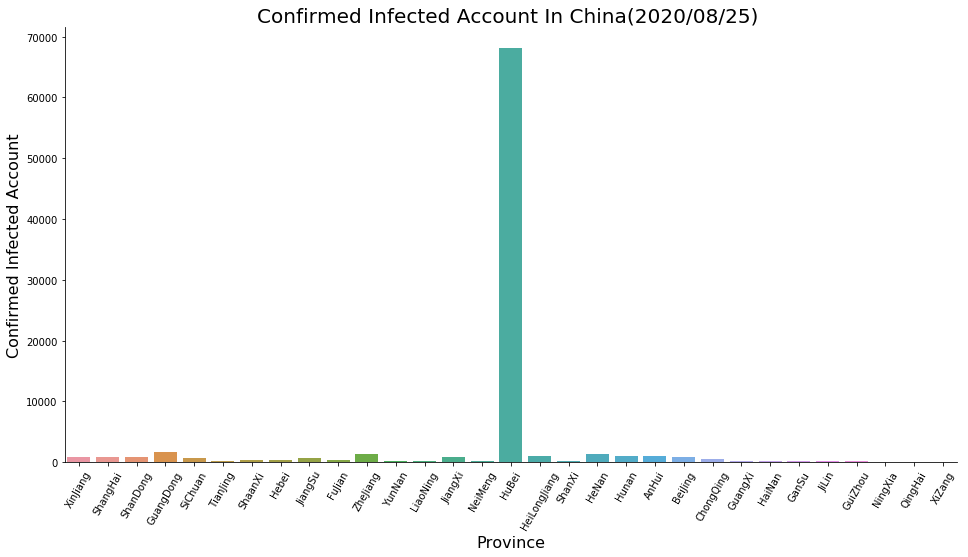

In [25]:
fig,ax=plt.subplots(figsize=(16,8))
sns.barplot(x="provinceName",y="confirmedCount",data=covid19_2)
for tick in ax.get_xticklabels():
    tick.set_rotation(60)
ax.set_title('Confirmed Infected Account In China(2020/08/25) ')
ax.set_ylabel('Confirmed Infected Account')
ax.set_xlabel('Province')
ax.title.set_fontsize(20)
ax.xaxis.label.set_fontsize(16)
ax.yaxis.label.set_fontsize(16)
sns.despine()
plt.savefig('ConfirmedInfectedAccountInChina_1.jpg')

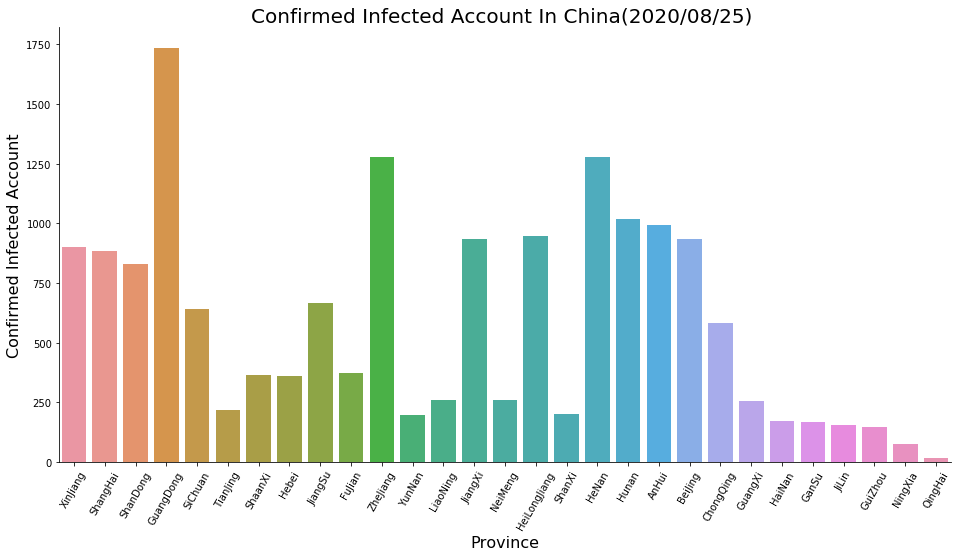

In [26]:
covid19_3=covid19_2[~covid19_2['provinceName'].isin(["HuBei"])]
covid19_3=covid19_3[~covid19_3['provinceName'].isin(["XiZang"])]
fig,ax=plt.subplots(figsize=(16,8))
sns.barplot(x="provinceName",y="confirmedCount",data=covid19_3)
for tick in ax.get_xticklabels():
    tick.set_rotation(60)
ax.set_title('Confirmed Infected Account In China(2020/08/25) ')
ax.set_ylabel('Confirmed Infected Account')
ax.set_xlabel('Province')
ax.title.set_fontsize(20)
ax.xaxis.label.set_fontsize(16)
ax.yaxis.label.set_fontsize(16)
sns.despine()
plt.savefig('ConfirmedInfectedAccountInChina_2.jpg')

### We will calculate a Infaction Index by the following function：
###        Infaction Index of Particular Province = (Infected Amount/Province Population) * 10000

In [27]:
population=pd.read_csv("data/Population.csv")
population

Province  Population
0        BeiJing        2154
1       TianJing        1560
2          HeBei        7556
3         ShanXi        3718
4        NeiMeng        2534
5       LiaoNing        4359
6          JiLin        2704
7   HeiLongJiang        3773
8       ShangHai        2424
9        JiangSu        8051
10      ZheJiang        5737
11         AnHui        6324
12        FuJian        3941
13       JiangXi        4648
14      ShanDong       10047
15         HeNan        9605
16         HuBei        5917
17         HuNan        6899
18     GuangDong       11346
19       GuangXi        4926
20        HaiNan         934
21     ChongQing        3102
22       SiChuan        8341
23       GuiZhou        3600
24        YunNan        4830
25        XiZang         344
26       ShaanXi        3864
27         GanSu        2637
28       QingHai         603
29       NingXia         688
30      XinJiang        2487

In [28]:
# 创建一个空的 DataFrame
from pandas.core.frame import DataFrame
infection_index =[]
for province1 in range(len(population['Province'])):
    for province2 in range(len(covid19_2['provinceName'])):
        if population['Province'][province1] == covid19_2['provinceName'][province2]:
            infectionindex=covid19_2['confirmedCount']/population['Population']
            infection_index.append(infectionindex)
            break
        break
infection_index

[0     0.418756
 1     0.567949
 2     0.109979
 3     0.466380
 4     0.252565
 5     0.050470
 6     0.134615
 7     0.095415
 8     0.274340
 9     0.046578
 10    0.222590
 11    0.031467
 12    0.066481
 13    0.201162
 14    0.025878
 15    7.094118
 16    0.160216
 17    0.029280
 18    0.112463
 19    0.206862
 20    1.061028
 21    0.301418
 22    0.069896
 23    0.070833
 24    0.035404
 25    0.491279
 26    0.040631
 27    0.055745
 28    0.124378
 29    0.026163
 30    0.000402
 dtype: float64]

In [29]:
infection_index_list=[0.418756,0.567949,
    0.109979,0.466380,0.252565,0.050470,
                      0.134615,0.095415,0.274340,0.046578,0.222590,0.031467,
                      0.066481,0.201162,0.025878,7.094118,0.160216,0.029280,0.112463,0.206862,
                      1.061028,0.301418,0.069896,0.070833,0.035404,0.491279,
                      0.040631,0.055745,0.124378,0.026163,0.000402,]
len(infection_index_list)

31

In [30]:
type(infection_index)
#infection_index.insert(0,"infection_index")
#infection_index

list

In [31]:
len(infection_index)
#print(infection_index)

1

In [32]:
type(population)

pandas.core.frame.DataFrame

In [33]:
from pandas.core.frame import DataFrame
covid19_2['infectionindex']=infection_index_list
#population = pd.DataFrame(columns=["infectionindex"] ,data=infection_index)

#population.insert(2,'infectionindex',infection_index)
covid19_2

provinceName    dateId  confirmedCount  infectionindex
0       XinJiang  20200825             902        0.418756
1       ShangHai  20200825             886        0.567949
2       ShanDong  20200825             831        0.109979
3      GuangDong  20200825            1734        0.466380
4        SiChuan  20200825             640        0.252565
5       TianJing  20200825             220        0.050470
6        ShaanXi  20200825             364        0.134615
7          Hebei  20200825             360        0.095415
8        JiangSu  20200825             665        0.274340
9         FuJian  20200825             375        0.046578
10      ZheJiang  20200825            1277        0.222590
11        YunNan  20200825             199        0.031467
12      LiaoNing  20200825             262        0.066481
13       JiangXi  20200825             935        0.201162
14       NeiMeng  20200825             260        0.025878
15         HuBei  20200825           68139        7.094118
16  HeiLongJiang  20200825             948        0.160216
17        ShanXi  20200825             202        0.029280
18         HeNan  20200825            1276        0.112463
19         Hunan  20200825            1019        0.206862
20         AnHui  20200825             991        1.061028
21       BeiJing  20200825             935        0.301418
22     ChongQing  20200825             583        0.069896
23       GuangXi  20200825             255        0.070833
24        HaiNan  20200825             171        0.035404
25         GanSu  20200825             169        0.491279
26         JiLin  20200825             157        0.040631
27       GuiZhou  20200825             147        0.055745
28       NingXia  20200825              75        0.124378
29       QingHai  20200825              18        0.026163
30        XiZang  20200825               1        0.000402

In [35]:
covid19_2.to_csv('data/corona_virus_of_china_2.csv',index=False)
covid19_2.head()

provinceName    dateId  confirmedCount  infectionindex
0     XinJiang  20200825             902        0.418756
1     ShangHai  20200825             886        0.567949
2     ShanDong  20200825             831        0.109979
3    GuangDong  20200825            1734        0.466380
4      SiChuan  20200825             640        0.252565

In [38]:
covid19_4=pd.read_csv('data/corona_virus_of_china_2.csv')
covid19_4.head()

provinceName    dateId  confirmedCount  infectionindex
0     XinJiang  20200825             902        0.418756
1     ShangHai  20200825             886        0.567949
2     ShanDong  20200825             831        0.109979
3    GuangDong  20200825            1734        0.466380
4      SiChuan  20200825             640        0.252565

In [41]:
Factors.head()

provinceName  Province  AvgSalary  AvgDisposableIncome  AvgSalaryofMedical  \
0          北京市   BeiJing     145766             62361.22             84725.0   
1          天津市  TianJing     100731             39506.15             52472.0   
2          河北省     HeBei      68717             23445.65             41185.0   
3          山西省    ShanXi      65917             21990.14             36832.0   
4       内蒙古自治区   NeiMeng      73835             28375.65             43148.0   

   AvgMedicalPerPerson  Unemployment  PopullationGrowth  \
0                  119          7.91               8.24   
1                   67         25.81               6.67   
2                   61         38.04              11.26   
3                   66         24.56               9.63   
4                   74         27.04               8.35   

   FolatingPopulationProportion  
0                         11.68  
1                          4.96  
2                          4.33  
3                          6.28  
4                         10.87

In [51]:
data_sum=pd.read_csv('data/DATA_SUM.csv')
data_sum.head()

Province  ConfirmedCount  Population  InfectionIndex  AvgMedicalPerPerson  \
0   BeiJing             935        2154        0.434076                  119   
1  TianJing             220        1560        0.141026                   67   
2     HeBei             360        7556        0.047644                   61   
3    ShanXi             202        3718        0.054330                   66   
4   NeiMeng             260        2534        0.102605                   74   

   AvgDisposableSalary  FolatingPopulationProportion  
0             62361.22                         11.68  
1             39506.15                          4.96  
2             23445.65                          4.33  
3             21990.14                          6.28  
4             28375.65                         10.87

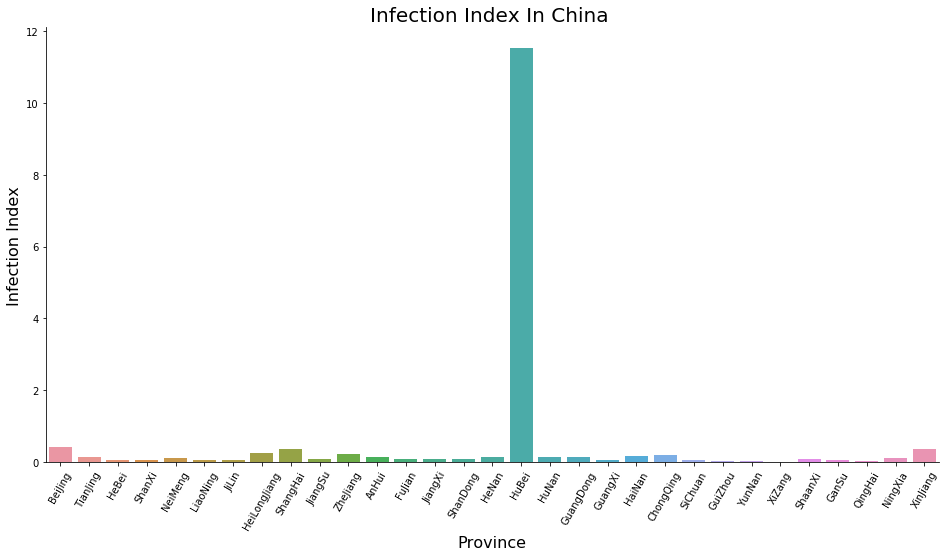

In [52]:
#covid19_5=covid19_4[~covid19_4['provinceName'].isin(["HuBei"])]
#covid19_5=covid19_5[~covid19_5['provinceName'].isin(["XiZang"])]
fig,ax=plt.subplots(figsize=(16,8))
sns.barplot(x="Province",y="InfectionIndex",data=data_sum)
for tick in ax.get_xticklabels():
    tick.set_rotation(60)
ax.set_title('Infection Index In China ')
ax.set_ylabel('Infection Index')
ax.set_xlabel('Province')
ax.title.set_fontsize(20)
ax.xaxis.label.set_fontsize(16)
ax.yaxis.label.set_fontsize(16)
sns.despine()
plt.savefig('InfectionIndexInChina.jpg')

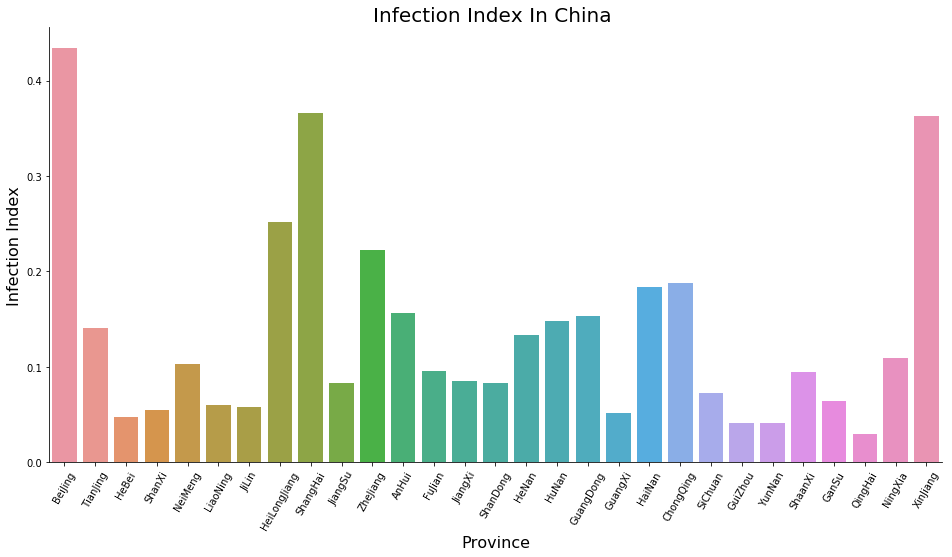

In [53]:
data_sum_1=data_sum[~data_sum['Province'].isin(["HuBei"])]
data_sum_1=data_sum_1[~data_sum_1['Province'].isin(["XiZang"])]
fig,ax=plt.subplots(figsize=(16,8))
sns.barplot(x="Province",y="InfectionIndex",data=data_sum_1)
for tick in ax.get_xticklabels():
    tick.set_rotation(60)
ax.set_title('Infection Index In China ')
ax.set_ylabel('Infection Index')
ax.set_xlabel('Province')
ax.title.set_fontsize(20)
ax.xaxis.label.set_fontsize(16)
ax.yaxis.label.set_fontsize(16)
sns.despine()
plt.savefig('InfectionIndexInChina_1.jpg')

### (4) Using Mechine Learning Method

### Relationship between Infection Index and three different Factors

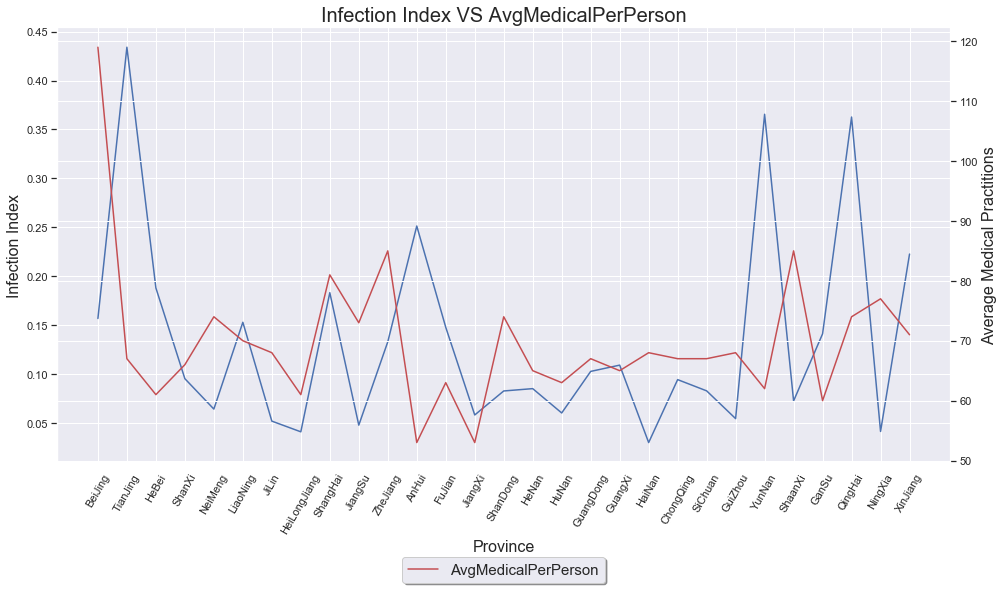

In [104]:
data_sum_1=data_sum[~data_sum['Province'].isin(["HuBei"])]
data_sum_1=data_sum_1[~data_sum_1['Province'].isin(["XiZang"])]
x = data_sum_1['Province']
y1 = data_sum_1['InfectionIndex']
y2 = data_sum_1['AvgMedicalPerPerson']
fig,ax=plt.subplots(figsize=(16,8))
sns.lineplot(x="Province",y="InfectionIndex",data=data_sum_1)
for tick in ax.get_xticklabels():
    tick.set_rotation(60)
ax.set_title('Infection Index VS AvgMedicalPerPerson')
ax.set_ylabel('Infection Index')
ax.set_xlabel('Province')
ax.title.set_fontsize(20)
ax.xaxis.label.set_fontsize(16)
ax.yaxis.label.set_fontsize(16)
#ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),fontsize=15,fancybox=True, shadow=True, ncol=5)
sns.despine()
ax2 = ax.twinx()
ax2.plot(x, y2, 'r',ms=10)
ax2.set_ylabel('Average Medical Practitions',fontsize='16')
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),fontsize=15,fancybox=True, shadow=True, ncol=5)

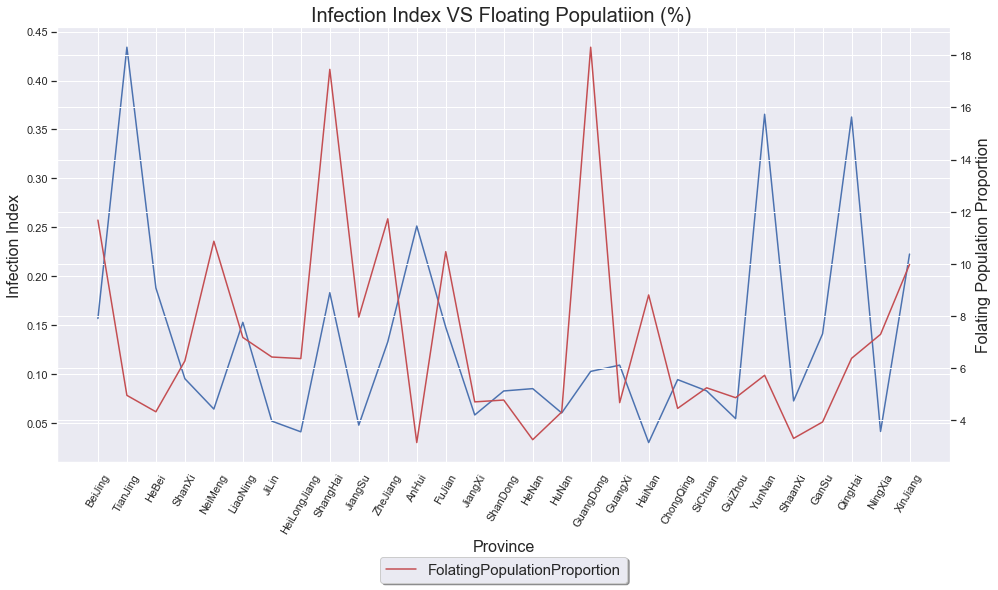

In [105]:
x = data_sum_1['Province']
y1 = data_sum_1['InfectionIndex']
y2 = data_sum_1['FolatingPopulationProportion']
fig,ax=plt.subplots(figsize=(16,8))
sns.lineplot(x="Province",y="InfectionIndex",data=data_sum_1)
for tick in ax.get_xticklabels():
    tick.set_rotation(60)
ax.set_title('Infection Index VS Floating Populatiion (%) ')
ax.set_ylabel('Infection Index')
ax.set_xlabel('Province')
ax.title.set_fontsize(20)
ax.xaxis.label.set_fontsize(16)
ax.yaxis.label.set_fontsize(16)
sns.despine()
ax2 = ax.twinx() 
ax2.plot(x, y2, 'r',ms=10)
ax2.set_ylabel('Folating Population Proportion',fontsize='16')
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),fontsize=15,fancybox=True, shadow=True, ncol=5)

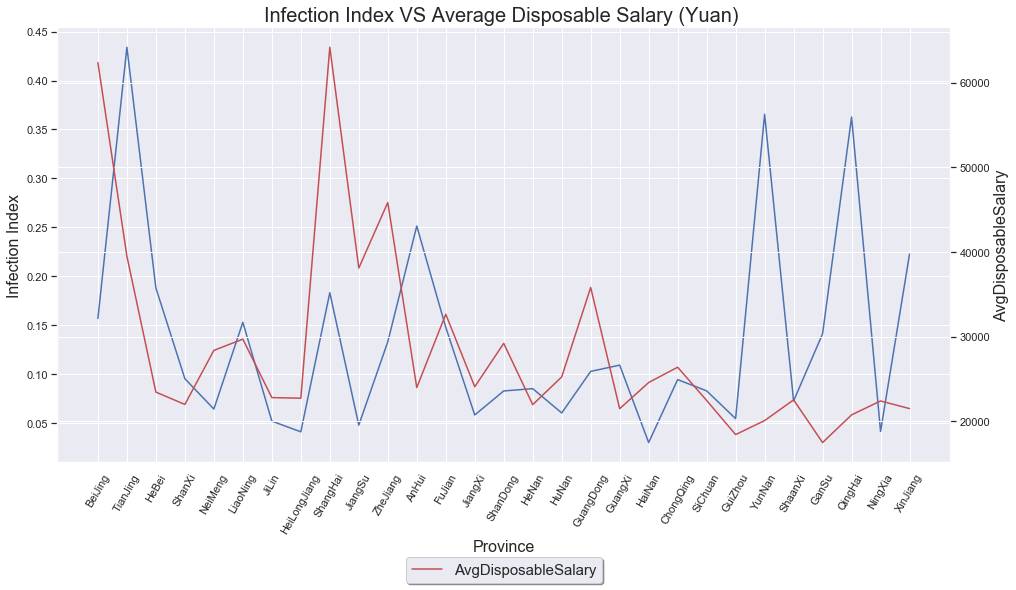

In [106]:
x = data_sum_1['Province']
y1 = data_sum_1['InfectionIndex']
y2 = data_sum_1['AvgDisposableSalary']
fig,ax=plt.subplots(figsize=(16,8))
sns.lineplot(x="Province",y="InfectionIndex",data=data_sum_1)
for tick in ax.get_xticklabels():
    tick.set_rotation(60)
ax.set_title('Infection Index VS Average Disposable Salary (Yuan) ')
ax.set_ylabel('Infection Index')
ax.set_xlabel('Province')
ax.title.set_fontsize(20)
ax.xaxis.label.set_fontsize(16)
ax.yaxis.label.set_fontsize(16)
sns.despine()
ax2 = ax.twinx() 
ax2.plot(x, y2, 'r',ms=10)
ax2.set_ylabel('AvgDisposableSalary',fontsize='16')
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),fontsize=15,fancybox=True, shadow=True, ncol=5)

## OLS Regression
   ### We run a OLS regression using "Infection Index  " as the dependent variable and "Average Disposable Salary" ,  "Floating Population Propotion" and " Average Medical Practitions" as the independent variables.

In [114]:
import numpy as np
import pandas as pd
#import statsmodels.api as sm #方法一
import statsmodels.formula.api as smf #方法二
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
 
X = data_sum_1[["AvgDisposableSalary", "FolatingPopulationProportion", "AvgMedicalPerPerson"]]
y = data_sum_1["InfectionIndex"]
 
#est = sm.OLS(y, sm.add_constant(X)).fit() #方法一
est = smf.ols(formula='InfectionIndex ~ AvgDisposableSalary + FolatingPopulationProportion + AvgMedicalPerPerson', data=data_sum_1).fit() #方法二
y_pred = est.predict(X)
 
data_sum_1['InfectionIndex'] = y_pred
print(data_sum_1)
print(est.summary()) #回归结果
print(est.params) #系数
 
#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d') #ax = Axes3D(fig)
#ax.scatter(X['AvgDisposableSalary'], X['FolatingPopulationProportion'],X['AvgMedicalPerPerson'], y, c='b', marker='o')
#ax.scatter(X['AvgDisposableSalary'], X['FolatingPopulationProportion'], X['AvgMedicalPerPerson'],y_pred, c='r', marker='+')
#ax.set_xlabel('X Label')
#ax.set_ylabel('Y Label')
#ax.set_zlabel('Z Label')


        Province  ConfirmedCount  Population  InfectionIndex  \
0        BeiJing             935        2154        0.366038   
1       TianJing             220        1560        0.161136   
2          HeBei             360        7556        0.087329   
3         ShanXi             202        3718        0.098978   
4        NeiMeng             260        2534        0.157110   
5       LiaoNing             262        4359        0.138969   
6          JiLin             157        2704        0.106110   
7   HeiLongJiang             948        3773        0.093638   
8       ShangHai             886        2424        0.333758   
9        JiangSu             665        8051        0.179310   
10      ZheJiang            1277        5737        0.245772   
11         AnHui             991        6324        0.070503   
12        FuJian             375        3941        0.152745   
13       JiangXi             395        4648        0.077775   
14      ShanDong             831       1

In [115]:
data_sum_1.head()

Province  ConfirmedCount  Population  InfectionIndex  AvgMedicalPerPerson  \
0   BeiJing             935        2154        0.366038                  119   
1  TianJing             220        1560        0.161136                   67   
2     HeBei             360        7556        0.087329                   61   
3    ShanXi             202        3718        0.098978                   66   
4   NeiMeng             260        2534        0.157110                   74   

   AvgDisposableSalary  FolatingPopulationProportion  
0             62361.22                         11.68  
1             39506.15                          4.96  
2             23445.65                          4.33  
3             21990.14                          6.28  
4             28375.65                         10.87

In [121]:
type(data_sum_1["AvgMedicalPerPerson"])

pandas.core.series.Series

In [157]:
from sklearn.datasets import load_iris, fetch_20newsgroups, load_boston
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
#from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.feature_extraction import DictVectorizer
def decision():
    x = data_sum_1[["AvgDisposableSalary", "FolatingPopulationProportion", "AvgMedicalPerPerson"]]
    y = data_sum_1[["InfectionIndex"]]
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25)
    print(x)
    #x['AvgDisposableSalary'].fillna(x['AvgDisposableSalary'].mean(),inplace=True)
    dict = DictVectorizer(sparse = False)
    dict.fit_transform(x_train.to_dict(orient='records'))
    print(dict.get_feature_names())
    x_test = dict.transform(x_test.to_dict(orient="records"))
    print(x_train)
    dec = DecisionTreeClassifier(max_depth=5)
    dec.fit(x_train, y_train.astype("int"))
    rf = RandomForestClassifier()

    param = {"n_estimators": [120, 200, 300, 500, 800, 1200], "max_depth": [5, 8, 15, 25, 30]}

    gc = GridSearchCV(rf, param_grid=param, cv=2)

    gc.fit(x_train, y_train.astype("int"))
    print("the accuracy of predict is ",dec.score(x_test,y_test,**fit_params))

    return None

    
if __name__ == "__main__":
    decision()

    AvgDisposableSalary  FolatingPopulationProportion  AvgMedicalPerPerson
0              62361.22                         11.68                  119
1              39506.15                          4.96                   67
2              23445.65                          4.33                   61
3              21990.14                          6.28                   66
4              28375.65                         10.87                   74
5              29701.45                          7.18                   70
6              22798.37                          6.43                   68
7              22725.85                          6.37                   61
8              64182.65                         17.46                   81
9              38095.79                          7.96                   73
10             45839.84                         11.73                   85
11             23983.58                          3.15                   53
12             32643.93  

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y wa

KeyboardInterrupt: 